In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Carica tutte le associazioni pattern:relazione effettivamente utlizzate per estrarre fatti
pat2rel_full = pd.read_csv('../output_data/pattern2relation.tsv', sep='\t', keep_default_na=False)

# Mostra associazioni note
pat2rel_full

,subject_type,phrase,object_type,relation
0,[City],is a city in,[AdministrativeRegion],isPartOf
1,[Town],is a township in,[AdministrativeRegion],isPartOf
2,[Settlement],is a village in,[AdministrativeRegion],region
3,[Settlement],is a census-designated place in,[Settlement],isPartOf
4,[Settlement],in,[Settlement],isPartOf
...,...,...,...,...
102086,[PopulatedPlace],villages of,[Settlement],part
102087,[EthnicGroup],regions in,[Country],populationPlace
102088,[HorseRace],on firm ground at,[Racecourse],location
102089,[AdministrativeRegion],", where they settled in",[City],part


In [3]:
# Carica tutte le associazioni pattern:relazione che sono state scartate da deflector (sottinsieme di pat2rel_full)
pat2rel_banned = pd.read_csv('../output_data/banned_patterns.tsv', sep='\t', keep_default_na=False)

# Mostra associazioni scartate
pat2rel_banned

,subject_type,phrase,object_type,relation
0,[Settlement],is a census-designated place in,[Settlement],isPartOf
1,[Settlement],in,[Settlement],isPartOf
2,[Settlement],is a census-designated place in,[AdministrativeRegion],isPartOf
3,[Settlement],is a borough in,[AdministrativeRegion],isPartOf
4,[Town],is a town in,[AdministrativeRegion],isPartOf
...,...,...,...,...
8028,[AdministrativeRegion],", as well as in",[City],part
8029,[Country],"from #YEAR# to #YEAR#,",[City],capital
8030,[AdministrativeRegion],bar and practiced law in,[City],part
8031,[Country],musical group from,[City],largestCity


In [4]:
# Conversione in dizionari: relazione->conteggio pattern
rel2count_full = pat2rel_full['relation'].value_counts().to_dict()
rel2count_banned = pat2rel_banned['relation'].value_counts().to_dict()

# Costruzione dizionario: relazione->(pattern totali, pattern scartati)
rel2pairCount = dict()
for relation, full_count in rel2count_full.items():
    
    try:
        banned_count = rel2count_banned[relation]
    except:
        banned_count = 0
        
    rel2pairCount[relation] = (full_count, banned_count)

In [5]:
def plot_banned(data, top_k=10, relations=None):

    relations_axis = []
    full_counts_axis = []
    banned_counts_axis = []
    for k, rel2counts in enumerate(data):

        relation, counts = rel2counts
        full_count, banned_count = counts

        if not relations or (relation in relations):
            relations_axis.append(relation)
            full_counts_axis.append(full_count)
            banned_counts_axis.append(banned_count)
        
        
        if k == top_k:
            break         
        
    # Imposta la palette di colori da usare
    sns.set_color_codes('bright')

    # Inizializza area grafico
    ax = plt.subplots(figsize=(16,8))

    # Plotta dati
    ax = sns.barplot(x=relations_axis, y=full_counts_axis, color='g', alpha=.6, label='# Known Patterns')
    ax = sns.barplot(x=relations_axis, y=banned_counts_axis, color='r', alpha=.6, label='# Banned Patterns')

    # Formatta assi ed etichette
    ax.axes.set_title(f'Top {top_k} # patterns by relations',fontsize=15)
    ax.set_xlabel('Relations',fontsize=15)
    ax.set_ylabel('# Pattern',fontsize=15)
    ax.tick_params(labelsize=15)
    
    # Imposta legenda
    ax.legend(ncol=1, loc='upper right', frameon=True, fontsize=15)

    # Ruota etichette relazioni
    plt.xticks(rotation=90)

    # visulaizing illustration
    plt.show()

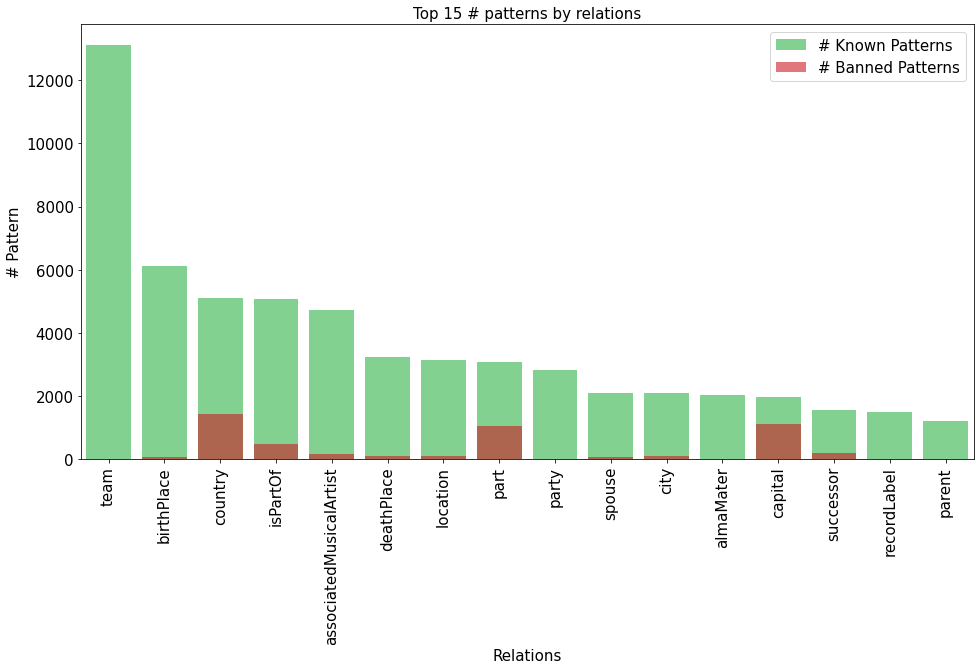

In [6]:
# Ordina per conteggio max dei pattern totali
sorted_by_full = sorted(rel2pairCount.items(), key=lambda x: x[1][0], reverse=True)

# Mostra grafico
plot_banned(sorted_by_full, top_k=15)

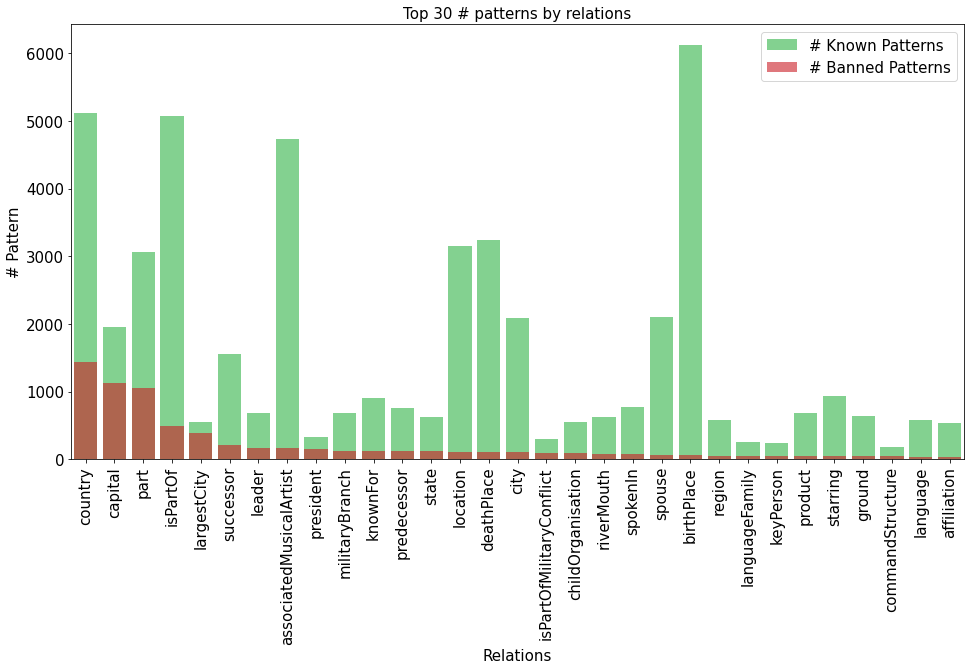

In [7]:
# Ordina per conteggio max dei pattern scartati
sorted_by_banned = sorted(rel2pairCount.items(), key=lambda x: x[1][1], reverse=True)

# Mostra grafico
plot_banned(sorted_by_banned, top_k=30)

## Precision \& Recall

###### PRECISION: pattern correttamente scartati su totale dei pattern scartati

###### RECALL: pattern correttamente scartati su totale dei pattern da scartare

In [36]:
# Carica ground truth
real_gt = pd.read_csv('ground_truth.tsv', sep='\t', keep_default_na=False)

# Conversione in liste di tuple
real_gt_rec = list([tuple(x) for x in real_gt.to_records(index=False)])
real_bp_rec = list([tuple(x) for x in pat2rel_banned.to_records(index=False)])

In [37]:
# Strutture di test usate per debuggare la funzione precallscores
gt_test = [('a', 'zzzzz', 'b', 'spouse', 0), 
           ('c', 'yyyyy', 'd', 'birthPlace', 1),
           ('e', 'xxxxx', 'f', 'spouse', 2),
           ('g', 'sssss', 'h', 'birthPlace', 0),
           ('i', 'ttttt', 'j', 'birthPlace', 1),
           ('k', 'qqqqq', 'l', 'spouse', 1)]

bp_test = [('k', 'qqqqq', 'l', 'spouse'),
           ('e', 'xxxxx', 'f', 'spouse'),
           ('g', 'sssss', 'h', 'birthPlace'),
           ('a', 'zzzzz', 'b', 'spouse')]

In [38]:
# Calcola i valori di Precision e Recall, per una relazione particolare o complessiva
# La precision misura quanti pattern sono stati scartati correttamente da deflector
# La Recall misura quanti pattern totali sono
def precallscores(ground_truth, banned_patterns, target_relation=None):
    
    # Step 0
    if target_relation:
        gt = [x for x in ground_truth if x[3] == target_relation]
        bp = [x for x in banned_patterns if x[3] == target_relation]
    else:
        gt = ground_truth
        bp = banned_patterns
    
    # Step 1
    record2truth = dict() # Struttura per indicizzare i pattern
    relevant = 0
    for record in gt:        
        record2truth[record[:-1]] = record[-1]
        if record[-1] == 0:
            relevant += 1 # Se è da scartare contalo come rilevante
        
    # Step 2
    true_positive = 0
    bannedCount = 0
    for record in bp:        
        isValid = record2truth[record]
        if isValid == 0:
            # Questo pattern è stato correttamente bannato
            true_positive += 1 # Contalo come true positive     
        if isValid == 0 or isValid == 1:
            # Questo pattern è stato valutato nella ground truth
            bannedCount += 1 # Contalo nel totale dei pattern bannati
    
    try:
        precision = true_positive/bannedCount
        recall = true_positive/relevant
    except:
        precision, recall = -1, -1 # Gestisce eventuali errori per mostrarli graficamente
    
    
    return precision, recall               

In [39]:
# Relazioni di cui saranno calcolati gli score di precision e recall
target_relations = ['spouse', 'birthPlace', 'deathPlace']

In [40]:
# Inizializza dizionario: relazione-> (precision, recall)
# 'Overall' considera gli score complessivi su tutte le relazioni
precall_dict = {'OVERALL': precallscores(real_gt_rec, real_bp_rec)}

# Calcola valori di precision e recall per ciascuna relazione
for r in target_relations:
    precall_dict[r] = precallscores(real_gt_rec, real_bp_rec, r)

In [41]:
# Mostra grafico precision e recall
def plot_precall(data_dict):
    
    records = []
    for rel, pANDr in data_dict.items():
        records.append(('Precision', rel, pANDr[0]))
        records.append(('Recall', rel, pANDr[1]))
    
    df = pd.DataFrame(records, columns=['Metric', 'Relation', 'Score'])
    
    
    # Imposta la palette di colori da usare
    sns.set_color_codes('bright')

    # Crea il grafico
    ax = plt.subplots(figsize=(16,8))
    
    # Crea valori
    ax = sns.barplot(x='Relation', y='Score', hue='Metric', data=df, palette='terrain')
    
    
    # Formattazione etichette
    ax.axes.set_title(f'Precision vs. Recall',fontsize=15)
    ax.set_xlabel('Relations',fontsize=15)
    ax.set_ylabel('Score',fontsize=15)
    ax.tick_params(labelsize=15)
    
    # Imposta legenda
    ax.legend(ncol=1, loc='upper right', frameon=True, fontsize=15)

    # Ruota etichette relazioni
    plt.xticks(rotation=45)

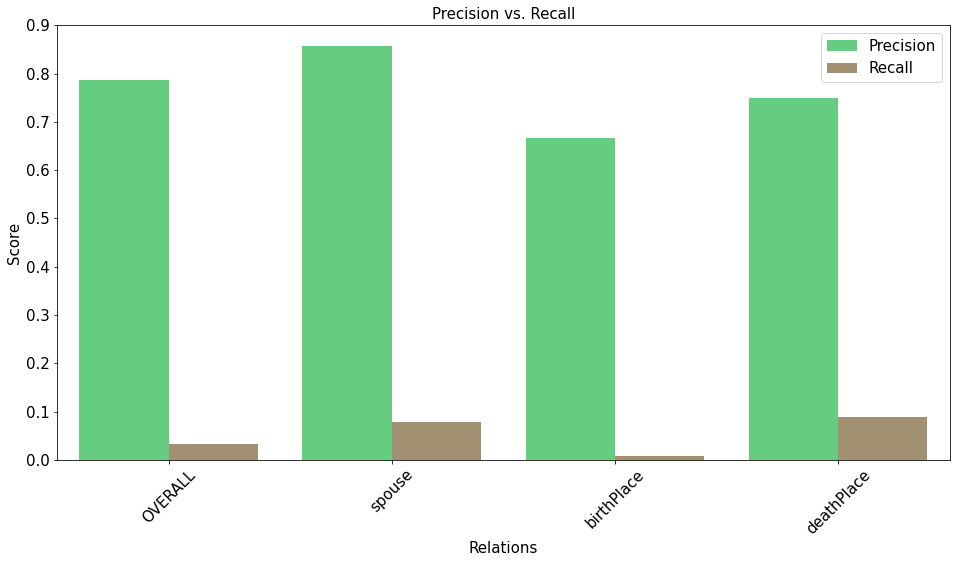

In [42]:
plot_precall(precall_dict)